In [1]:
import pickle
import matplotlib.pyplot as plt

with open("results.pkl", "rb") as f:
    results = pickle.load(f)


FileNotFoundError: [Errno 2] No such file or directory: 'results.pkl'

In [ ]:
similarity_values = [value[3] for value in results.values()]
number = [value[4] for value in results.values()]

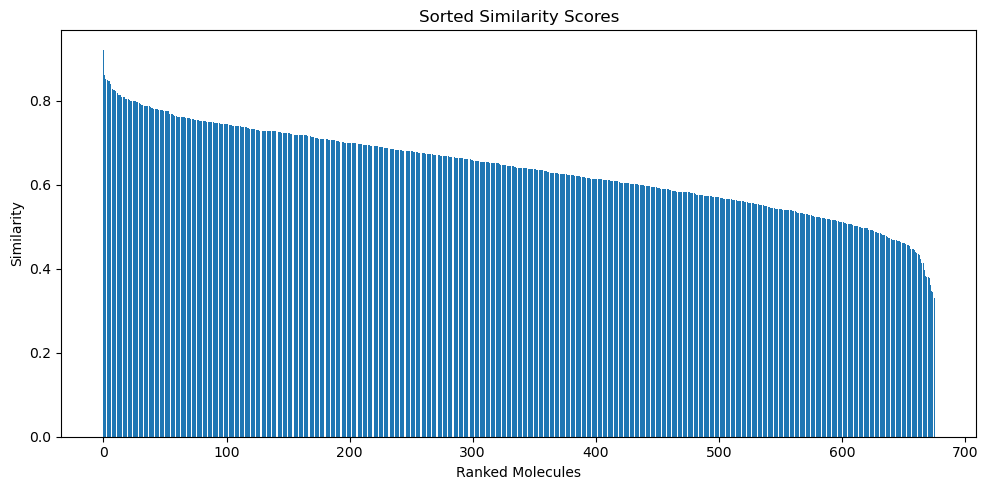

In [ ]:
sorted_values = sorted(similarity_values, reverse=True)

plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_values)), sorted_values)
plt.xlabel("Ranked Molecules")
plt.ylabel("Similarity")
plt.title("Sorted Similarity Scores")
plt.tight_layout()
#plt.savefig("tmp/exp/sorted_similarity_barplot.png")
plt.show()


In [ ]:
print(sorted_values[0])

0.9260928221144821


In [ ]:
pairs = list(zip(similarity_values, number))

# 排序取 top 10
top_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)[:10]

# 拆分为两个列表
top_similarities = [x[0] for x in top_pairs]
top_numbers = [x[1] for x in top_pairs]



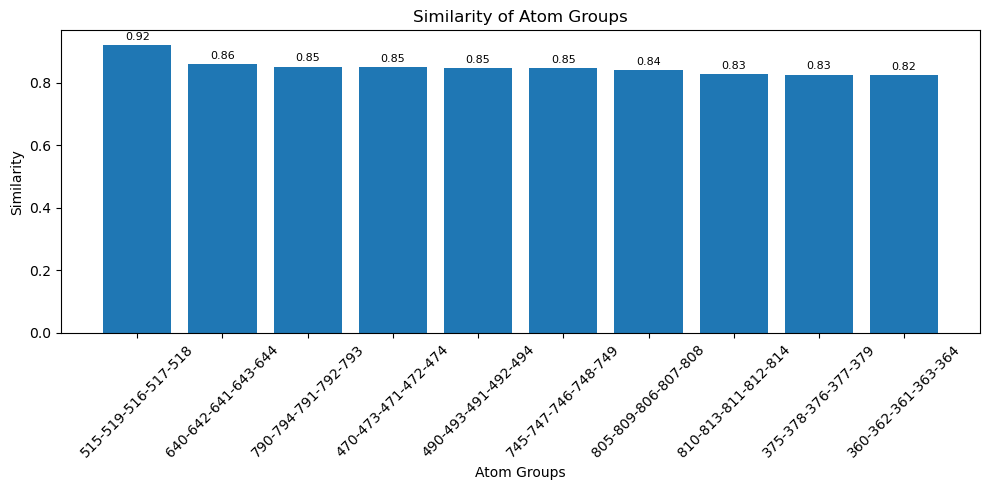

In [ ]:
labels = ['-'.join(map(str, group)) for group in top_numbers]

# 画图
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(top_similarities)), top_similarities, tick_label=labels)
plt.xlabel("Atom Groups")
plt.ylabel("Similarity")
plt.title("Similarity of Atom Groups")
plt.xticks(rotation=45)  # x轴文字旋转，防止重叠

# 添加数值标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,  # 上方略微留白
             f"{top_similarities[i]:.2f}",  # 保留两位小数
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


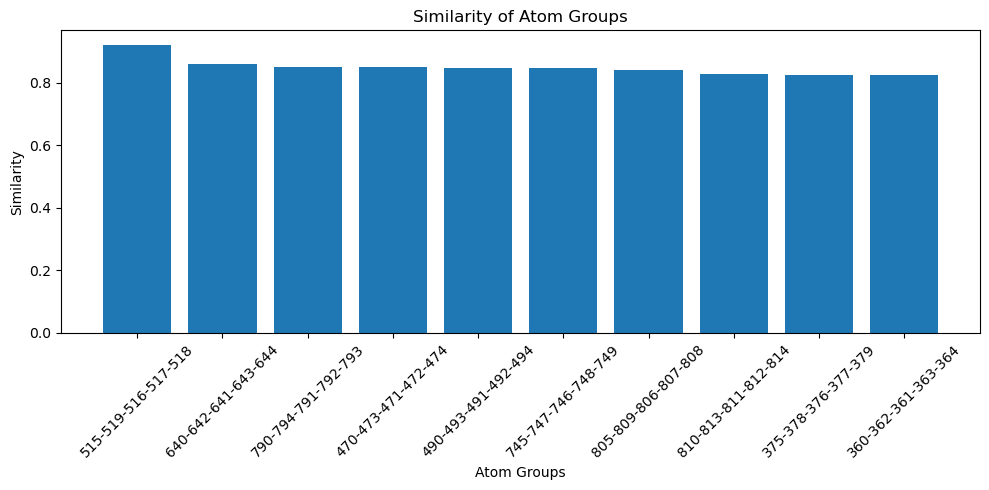

In [ ]:
labels = ['-'.join(map(str, group)) for group in top_numbers]

# 画图
plt.figure(figsize=(10, 5))
plt.bar(range(len(top_similarities)), top_similarities, tick_label=labels)
plt.xlabel("Atom Groups")
plt.ylabel("Similarity")
plt.title("Similarity of Atom Groups")
plt.xticks(rotation=45)  # x轴文字旋转，防止重叠
plt.tight_layout()
plt.show()